In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sympy as sp
import scipy as sc
from scipy.sparse import lil_matrix, csr_matrix, hstack, vstack
from collections import Counter
from math import comb
from tqdm import tqdm
from collections import defaultdict
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import FancyArrowPatch
import math
import time
import itertools
import random
import os


def largerBin_old(num): #Given a decimal integer, returns a supersetof all possible states that it can reach in one iteration
    nums = []
    binary = d2b(num)
    zeroIndices = []
    for i in range(len(binary)):
        if binary[i] == "0":
            zeroIndices.append(n-i-1) 
    for i in range(len(zeroIndices)+1):
        for subset in itertools.combinations(zeroIndices, i):
            temp = num
            for j in subset:
                temp += 2**j
            nums.append(temp)
    return sorted(nums)

def largerBin(num, graphs): #This one checks the edges for possibilities first. Gives all possible states that it can reach in one iteration
    nums = []
    binary = d2b(num)
    blueIndices = []
    whiteIndices = []
    possibleIndices = []
    for i in range(len(binary)):
        if binary[i] == "0":
            whiteIndices.append(n-i-1)
        else:
            blueIndices.append(n-i-1)
    for i in whiteIndices:
        if len(set(blueNeighbors(graphs[num], i)).intersection(set(blueIndices))) > 0:
            possibleIndices.append(i)
    for i in range(len(possibleIndices)+1):
        for subset in itertools.combinations(possibleIndices, i):
            temp = num
            for j in subset:
                temp+= 2**j
            nums.append(temp)
    return sorted(nums)

def largerBin_directed_newRule(num, graphs):
    nums = []
    binary = d2b(num)
    blueIndices = []
    whiteIndices = []
    possibleIndices = []
    for i in range(len(binary)):
        if binary[i] == "0":
            whiteIndices.append(n-i-1)
        else:
            blueIndices.append(n-i-1)
    for i in blueIndices:
        for j in graphs[num].successors(i):
            if j not in blueIndices and j not in possibleIndices:
                possibleIndices.append(j)
    for i in range(len(possibleIndices)+1):
        for subset in itertools.combinations(possibleIndices, i):
            temp = num
            for j in subset:
                temp+= 2**j
            nums.append(temp)        
    return sorted(nums)

def sameOnes(num): #Given a decimal integer, returns all other numbers with the same number of 1 bits. 
    ones = bin(num).count("1")
    ans = []
    for i in range(2**n):
        if bin(i).count("1") == ones:
            ans.append(i)
    return ans

def sameOnes_larger(num):
    ones = bin(num).count("1")
    ans = []
    for i in range(num, 2**n):
        if bin(i).count("1") == ones:
            ans.append(i)
    return ans

def extract(lst):
    return [item[0] for item in lst]

def d2b(i): #Function to return the string of the binary representation of an integer with n digits. 
    binaryString = str(bin(i))[2:]
    while(len(binaryString) < n):
        binaryString = "0" + binaryString
    return binaryString

def b2d(bin): #Function to return the decimal represenation of a binary number
    dec = 0
    for i in range(len(bin)):
        dec += int((bin[n-i-1]))*(2**i)
    return dec

def transitionPossible(i,j): #Function to return whether graph i (based on the binary rep. of i) can transition to j
    graphi = d2b(i)
    graphj = d2b(j)
    for k in range(len(graphi)):
        if graphi[k] == "1" and graphj[k] == "0":
            return False
    return True

def differingDigits(i,j): #Given 2 integers, function returns the digits/nodes that need to be forced
    num1Rev = d2b(i)[::-1]
    num2Rev = d2b(j)[::-1]
    output = []
    for i in range(len(num1Rev)):
        if num1Rev[i] != num2Rev[i]:
            output.append(i)
    return output

def sameZeros(i,j): #Given 2 integers,returns the indices of digits that are zero in both
    num1Rev = d2b(i)[::-1]
    num2Rev = d2b(j)[::-1]
    output = []
    for i in range(len(num1Rev)):
        if num1Rev[i] == num2Rev[i] and num1Rev[i] == "0":
            output.append(i)
    return output

def blueNeighbors(graph, node): #Given a node and a graph, returns a list of its neighbors that are blue
    output = []
    for i in graph.neighbors(node):
        if graph.nodes[i]['color'] == 'blue':
            output.append(i)
    return output

def blueSuppliers(graph, node):
    output = []
    for i in list(graph.predecessors(node)):
        if graph.nodes[i]['color'] == 'blue':
            output.append(i)
    return output

def numBlueNeighbors(graph): #Given a graph, returns an array of how many blue neighbors each node has
    output = []
    for i in range(n):
        output.append(len(blueNeighbors(graph, i)))
    return output

def numBlueSuppliers(graph):
    output = []
    for i in range(n):
        output.append(len(blueSuppliers(graph, i)))
    return output

def forcedProb(graph, node, numBlueNeighbors):
    temp = 1
    for i in blueNeighbors(graph, node):
        deg = graph.degree[i]
        numBlueNeighborsi = numBlueNeighbors[i]
        iforcesnodeprob = (numBlueNeighborsi+1)/deg
        idoesntforcenodeprob = 1 - iforcesnodeprob
        temp *= idoesntforcenodeprob
    return (1-temp)

def forcedProb_Directed(graph, node):
    suppliers = list(graph.predecessors(node))
    if len(suppliers) == 0:
        return 0
    isWeighted = True
    for edge in graph.in_edges(node):
        if 'weight' not in graph.edges[edge]:
            isWeighted = False 
    if not isWeighted:
        return len(blueSuppliers(graph, node))/len(suppliers)
    else:
        weightSum = 0
        blueWeightSum = 0 #if blueweightsum is 0, then the prob is 0
        for i in suppliers:
            weight = graph[i][node].get('weight')
            weightSum += weight
            if graph.nodes[i]['color'] == 'blue':
                blueWeightSum += weight
        return blueWeightSum/weightSum

def numswithbitcount(max, ones):
    nums = []
    for i in range(max):
        if d2b(i).count("1") == ones:
            nums.append(i)
    return nums

    pos = compute_layout(G, seed=seed)

    fig, ax = plt.subplots(figsize=(8, 6), dpi=140)

    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_color="skyblue", node_size=1200,
        edgecolors="black", linewidths=0.8
    )
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=11)

    # Edge widths independent of layout; normalize nicely
    def ew(d): 
        return float(d.get("weight", 1.0))
    edges = list(G.edges(data=True))
    w = np.array([ew(d) for _,_,d in edges], dtype=float) if edges else np.array([])
    if w.size and not np.all(w == w[0]):
        wn = (w - w.min()) / (w.max() - w.min())
        widths = list(1.5 + 3.5*wn)
    else:
        widths = [2.0]*len(edges)

    nx.draw_networkx_edges(
        G, pos, ax=ax,
        arrows=G.is_directed(), arrowsize=16, arrowstyle="-|>" if G.is_directed() else "-",
        connectionstyle="arc3,rad=0.08" if G.is_directed() else "arc3,rad=0.0",
        width=widths, edge_color="gray", alpha=0.9
    )

    if show_weights and edges:
        labels = {(u, v): d.get("weight", "") for u, v, d in edges}
        nx.draw_networkx_edge_labels(
            G, pos, ax=ax, edge_labels=labels, font_size=9, font_color="red",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
        )

    ax.set_axis_off()
    fig.tight_layout()
    plt.show()

def print_graph(G):
    pos = nx.spring_layout(G, seed=42)  # simple spring layout
    plt.figure(figsize=(6, 4))
    nx.draw_networkx(
        G, pos,
        with_labels=True,
        node_color='skyblue',
        edge_color='gray',
        node_size=1500,
        font_size=12
    )
    edge_labels = {(u, v): d.get('weight', '') for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.axis('off')
    plt.show()

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6, 4))

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', edgecolors='black', node_size=1500)
    nx.draw_networkx_labels(G, pos, font_size=12)

    # Separate edges that have a reverse counterpart
    fwd_edges, back_edges = [], []
    for u, v in G.edges():
        if (v, u) in G.edges() and (v, u) not in fwd_edges:
            fwd_edges.append((u, v))
            back_edges.append((v, u))
        elif (v, u) not in G.edges():
            fwd_edges.append((u, v))

    # Draw curved arrows for both directions
    nx.draw_networkx_edges(
        G, pos,
        edgelist=fwd_edges,
        arrows=True, arrowsize=16, connectionstyle="arc3,rad=0.2",
        edge_color='gray'
    )
    nx.draw_networkx_edges(
        G, pos,
        edgelist=back_edges,
        arrows=True, arrowsize=16, connectionstyle="arc3,rad=-0.2",
        edge_color='gray'
    )

    # Edge labels for both directions, placed differently
    labels_fwd  = {(u, v): G[u][v].get('weight', '') for (u, v) in fwd_edges}
    labels_back = {(u, v): G[u][v].get('weight', '') for (u, v) in back_edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels_fwd,  label_pos=0.3, font_color='red')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels_back, label_pos=0.7, font_color='red')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

def print_graph_bidirectional(G):
    # Ensure directed so A->B and B->A are distinct
    if not G.is_directed():
        G = nx.DiGraph(G)

    pos = nx.spring_layout(G, seed=42, k=0.8)

    fig, ax = plt.subplots(figsize=(6, 4))
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue',
                           edgecolors='black', node_size=1200, linewidths=0.8)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=12)

    # helper to draw one curved arrow u->v
    def curved_arrow(u, v, rad):
        a = FancyArrowPatch(pos[u], pos[v],
                            connectionstyle=f"arc3,rad={rad}",
                            arrowstyle='-|>', mutation_scale=16,
                            lw=1.8, color='gray',
                            shrinkA=18, shrinkB=18,   # keep arrowheads off node centers
                            zorder=3, clip_on=False)
        ax.add_patch(a)

    # draw singles straight; pairs curved in opposite directions
    seen = set()
    singles = []
    for u, v in G.edges():
        if (u, v) in seen:
            continue
        if G.has_edge(v, u):
            curved_arrow(u, v,  0.25)
            curved_arrow(v, u,  0.25)
            seen.add((u, v)); seen.add((v, u))
        else:
            singles.append((u, v))
            seen.add((u, v))

    # draw single-direction edges as straight arrows (small curvature 0)
    for u, v in singles:
        curved_arrow(u, v, 0.0)

    # edge labels for both directions at different positions
    # (works even though we drew edges manually; labels use node positions)
    labels_fwd  = {(u, v): G[u][v].get('weight', '') for (u, v) in G.edges() if G.has_edge(v, u)}
    labels_back = {(v, u): G[v][u].get('weight', '') for (u, v) in G.edges() if G.has_edge(v, u)}
    if labels_fwd:
        nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=labels_fwd,
                                     label_pos=0.33, font_color='red',
                                     bbox=dict(fc='white', ec='none', alpha=0.7))
        nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=labels_back,
                                     label_pos=0.67, font_color='red',
                                     bbox=dict(fc='white', ec='none', alpha=0.7))

    # labels for single edges
    singles_labels = {(u, v): G[u][v].get('weight', '') for (u, v) in singles}
    if singles_labels:
        nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=singles_labels,
                                     label_pos=0.5, font_color='red',
                                     bbox=dict(fc='white', ec='none', alpha=0.7))

    ax.set_axis_off()
    fig.tight_layout()
    plt.show()

def save_graph_radius_ver(graph, radius, node, time, name):
    directory = "/Users/noah01px2019/Desktop/graphs"
    plt.figure()
    plt.title("Radius = " + str(radius) + " Starting node = " + str(node) + " Propogation time = " +str(time))
    file_path = os.path.join(directory, name)
    nx.draw(graph, with_labels=True)
    plt.savefig(file_path)
    plt.close()

def graph_gen(targetGraph):
    #start = time.process_time()
    n = targetGraph.number_of_nodes()
    numGraphs = 2**n
    graphs = [None]*(numGraphs)
    for i in range(numGraphs):
        binaryString = d2b(i)
        graph = targetGraph.copy()
        for j in range(n):
            if binaryString[n-j-1] == "1":
                graph.nodes[j]['color'] = "blue"
            else:
                graph.nodes[j]['color'] = "white"
        graphs[i] = graph
    #print("Time needed for graph creation = " + str(time.process_time() - start) + " seconds")
    return graphs

def graph_gen_sub(targetGraph, states):
    n = targetGraph.number_of_nodes()
    numGraphs = len(states)
    graphs = [None]*(numGraphs)
    for i in range(numGraphs):
        binaryString = d2b(states[i])
        graph = targetGraph.copy()
        for j in range(n):
            if binaryString[n-j-1] == "1":
                graph.nodes[j]['color'] = "blue"
            else:
                graph.nodes[j]['color'] = "white"
        graphs[i] = graph
    return graphs

def tm_generation_old(graphs): #outdated, quite slow
    start = time.process_time()
    tm = np.zeros([2**n,2**n])
    #The states of the transition matrix is stored as follows - the nth node being blue refers to a 1 in the nth digit of the binary expression of the state.
    for i in range(2**n): #Computing the transition rate matrix
        for j in range(2**n):
            stateigraph = graphs[i]
            numBlueNeighborsi = numBlueNeighbors(stateigraph)
            transitionCalculated = False
            while transitionCalculated == False:
                if transitionPossible(i,j) == False:
                    tm[i][j] = 0
                    transitionCalculated = True
                else:  
                    tm[i][j] = 1
                    for k in differingDigits(i, j): #all differing digits must go from 0 to 1, otherwise transition impossible. First consdiering probabilities of vertices being forced
                        tm[i][j] *= forcedProb(stateigraph, k, numBlueNeighborsi)
                    for m in sameZeros(i,j): #all 0s that stay as 0s must not have been forced!)
                        tm[i][j] *= (1-forcedProb(stateigraph, m, numBlueNeighborsi))
                    transitionCalculated = True
    tm[2**n-1][2**n-1] = 1
    #print("Time needed for Transition Matrix Generation = " + str(time.process_time() - start) + " seconds")
    return tm

def tm_generation(graphs): #for probabilistic zero forcing, undirected graphs
    if graphs[0].is_directed() == True:
        raise ValueError("Graphs must be undirected!")
    start = time.process_time()
    tm = np.zeros([2**n,2**n])
    #The states of the transition matrix is stored as follows - the nth node being blue refers to a 1 in the nth digit of the binary expression of the state.
    for i in range(2**n): #Computing the transition rate matrix, tqdm here
        for j in largerBin(i, graphs):
            stateigraph = graphs[i]
            numBlueNeighborsi = numBlueNeighbors(stateigraph)
            tm[i][j] = 1
            for k in differingDigits(i, j): #all differing digits must go from 0 to 1, otherwise transition impossible. First consdiering probabilities of vertices being forced
                tm[i][j] *= forcedProb(stateigraph, k, numBlueNeighborsi)
            for m in sameZeros(i,j): #all 0s that stay as 0s must not have been forced!
                tm[i][j] *= (1-forcedProb(stateigraph, m, numBlueNeighborsi))
    tm[2**n-1][2**n-1] = 1
    #print("Time needed for Transition Matrix Generation = " + str(time.process_time() - start) + " seconds")
    return tm, time.process_time() - start #delete the time after testing

def tm_generation_directed(graphs): #for randomized zero forcing, directed graphs
    if graphs[0].is_directed() == False:
        raise ValueError("Graphs must be directed!")
    start = time.process_time()
    tm = np.zeros([2**n,2**n])
    for i in range(2**n):
        for j in largerBin_directed_newRule(i, graphs):
            stateigraph = graphs[i]
            tm[i][j] = 1
            for k in differingDigits(i,j):
                tm[i][j] *= forcedProb_Directed(stateigraph, k)
            for m in sameZeros(i,j):
                tm[i][j] *= (1-forcedProb_Directed(stateigraph, m))
    tm[2**n-1][2**n-1] = 1
    #print("Time needed for Transition Matrix Generation = " + str(time.process_time() - start) + " seconds")
    return tm, time.process_time() - start #delete the time after testing

def tm_generation_directed_sparse(graphs):
    if not graphs[0].is_directed():
        raise ValueError("Graphs must be directed!")
    start = time.process_time()
    tm = lil_matrix((2**n, 2**n))
    for i in range(2**n):
        for j in largerBin_directed_newRule(i, graphs):
            stateigraph = graphs[i]
            prob = 1.0
            for k in differingDigits(i, j):
                prob *= forcedProb_Directed(stateigraph, k)
            for m in sameZeros(i, j):
                prob *= (1 - forcedProb_Directed(stateigraph, m))
            tm[i, j] = prob
    tm[2**n - 1, 2**n - 1] = 1.0
    return tm.tocsr(), time.process_time() - start

def tm_generation_sub(graphs, startingSet):
    start = time.process_time()
    tm = np.zeros([2**n,2**n])
    states = largerBin(startingSet, graphs)
    for i in states: #tqdm here
        for j in largerBin(i, graphs):
            stateigraph = graphs[i]
            numBlueNeighborsi = numBlueNeighbors(stateigraph)
            tm[i][j] = 1
            for k in differingDigits(i, j): #all differing digits must go from 0 to 1, otherwise transition impossible. First consdiering probabilities of vertices being forced
                tm[i][j] *= forcedProb(stateigraph, k, numBlueNeighborsi)
            for m in sameZeros(i,j): #all 0s that stay as 0s must not have been forced!
                tm[i][j] *= (1-forcedProb(stateigraph, m, numBlueNeighborsi))
    tm[2**n-1][2**n-1] = 1
    subtm = tm[np.ix_(states, states)]
    #print("Time needed for Transition Matrix Generation with submatrix of size " + str(len(states)) + " in " + str(time.process_time() - start) + " seconds")
    return subtm

def tm_generation_directed_sub(graphs,states): #use sub graphs for this one, grpahs length should equal states length
    if graphs[0].is_directed() == False:
       raise ValueError("Graphs must be directed!")
    start = time.process_time()
    numStates = len(states)
    tm = np.zeros([numStates,numStates])
    for i in range(numStates):
        stateigraph = graphs[i]
        for j in range(i,numStates): #j is the state itself
            if transitionPossible(states[i],states[j]):
                tm[i][j] = 1
                for k in differingDigits(states[i],states[j]):
                    tm[i][j] *= forcedProb_Directed(stateigraph, k)
                for m in sameZeros(states[i],states[j]):
                    tm[i][j] *= (1-forcedProb_Directed(stateigraph, m))
    tm[len(states)-1][len(states)-1] = 1
    #print("Time needed for Transition Matrix Generation = " + str(time.process_time() - start) + " seconds")
    return tm, time.process_time() - start #delete the time after testing

def tm_generation_directed_sub_sparse(graphs, states):
    if not graphs[0].is_directed():
        raise ValueError("Graphs must be directed!")
    start = time.process_time()
    numStates = len(states)
    tm = lil_matrix((numStates, numStates))
    
    for i in range(numStates):
        stateigraph = graphs[i]
        for j in range(i, numStates):
            if transitionPossible(states[i], states[j]):
                prob = 1.0
                for k in differingDigits(states[i], states[j]):
                    prob *= forcedProb_Directed(stateigraph, k)
                for m in sameZeros(states[i], states[j]):
                    prob *= (1 - forcedProb_Directed(stateigraph, m))
                tm[i, j] = prob

    tm[numStates - 1, numStates - 1] = 1.0
    return tm.tocsr(), time.process_time() - start

def path_binary_states(n):
    results = []
    center = n // 2 if n % 2 == 1 else n // 2 - 1

    for i in range(n):
        for j in range(i, n):
            if i <= center <= j:
                s = ['0'] * n
                for k in range(i, j + 1):
                    s[k] = '1'
                results.append(''.join(s))

    # Sort lexicographically (i.e. by binary string)
    results.sort()

    # Convert to integers
    return [int(x, 2) for x in results]

"""
#sanity check
rowSums = np.zeros(2**n)
for i in range(2**n):
    sum = 0
    for j in range(2**n):
        sum += tm[i][j]
    rowSums[i] = sum
print(rowSums)
"""
def propogation_time_solver_algebraic(tm): #Turns out this one is really slow. Use the other one!
    #Solving the system of equations to find expected number of steps until absorption
    mus = sp.symbols('mu0:%d'%2**n)
    a = sp.Matrix(tm)
    eqns = []
    for i in range(2**n):
        if i != (2**n-1):
            eqns.append(a.row(i).dot(mus) + 1 - (mus[i])) 
        else:
            eqns.append(a.row(i).dot(mus))
    ans = list(sp.linsolve(eqns[-(2**n-1):], mus[-(2**n-1):])) #Has no value for the empty starting set
    return ans

def propogation_time_solver(tm):
    start = time.process_time()
    size = len(tm)
    #The fastest one
    solutions = np.zeros(size)
    solutions[size-1] = 0
    for i in range(size-2, 0, -1):
        temp = calc_expected(tm, i, solutions)
        solutions[i] = temp
    solutions[0] = float('inf')
    #print("Solving for propogation time took " + str(time.process_time() - start) + " seconds")
    #return solutions
    return solutions, time.process_time() - start

def propogation_time_solver_sparse(tm):
    start = time.process_time()
    size = tm.shape[0]
    solutions = np.zeros(size)
    solutions[size - 1] = 0

    for i in range(size - 2, 0, -1):
        temp = calc_expected_sparse(tm, i, solutions)
        solutions[i] = temp

    solutions[0] = float('inf')
    return solutions, time.process_time() - start

def propogation_time_solver_inverse(tm): #This one uses the linalg method outlined in Hogben and Jesse's paper. It's Slow :(
    tm = tm[1:, 1:]
    size = len(tm)
    for row in tm:
        row[-1] -= 1
    start = time.process_time()
    temp = sc.linalg.solve_triangular(tm-np.identity(size),np.identity(size))
    #print("Finding an inverse took " + str(time.process_time() - start) + " seconds")
    vector = temp[:,size-1] + 1
    vector = np.insert(vector , 0, float('inf'))
    #return temp #vector
    return vector, time.process_time() - start

def calc_expected(tm, row, solutions):
    size = len(tm)
    temp = 0
    coefficient = 1-tm[row][row]
    if coefficient == 0:
        return float('inf')
    for i in range(row+1, size):
        if tm[row][i] != 0:
            temp += tm[row][i] * (solutions[i]+1)
    temp+= (1-coefficient)
    temp /= coefficient
    return temp

def can_be_calculated(tm, row, solutions):
    ans = True
    for i in range(2**n-1):
        if tm[row][i] != 0:
            if solutions[i] == 0 and i != row:
                ans = False
    return ans

def calc_expected_sparse(tm, row, solutions):
    temp = 0.0
    diagonal = tm[row, row]
    coefficient = 1 - diagonal

    if coefficient == 0:
        return float('inf')

    # Get the non-zero entries in the row
    row_data = tm.getrow(row)
    for idx, col in zip(row_data.indices, row_data.data):
        if idx != row and col != 0:
            temp += col * (solutions[idx] + 1)

    temp += (1 - coefficient)
    temp /= coefficient
    return temp

#generating arrays for zero forcing sets by size of intial set

def optimal_zfs_by_size(ptimes, size):
    solutions = []
    indices = numswithbitcount(2**n,size)
    min = ptimes[indices[0]]
    for i in indices:
        if ptimes[i] < min:
            min = ptimes[i]
    for i in indices:
        if ptimes[i] == min:
            solutions.append((i, min))
    return solutions #returns list with two elements. first element contains all zfs that achieve the min time, second elment is the min time

def print_zfs(targetGraph, num, graphs, transitionTimes):
    color_map = []
    for i in range(n):
        if graphs[num].nodes[i]['color'] == 'blue':
            color_map.append('blue')
        else: 
            color_map.append('white')      
    plt.title("Expected Propogation Time = " + str(transitionTimes[num]))
    nx.draw(targetGraph, node_color=color_map, with_labels=True)
    plt.show()

def save_zfs(targetGraph, num, graphs, title, transitionTimes):
    color_map = []
    for i in range(n):
        if graphs[num].nodes[i]['color'] == 'blue':
            color_map.append('blue')
        else: 
            color_map.append('white')  
    pos = nx.spring_layout(graphs[num], k = 1)
    plt.figure()    
    plt.title("Expected Propogation Time = " + str(transitionTimes[num]))
    nx.draw(targetGraph, node_color=color_map, with_labels=True)
    plt.savefig(title)

def return_automorphic_states(graphs,index,automorphicKeys):
    key = tuple(blue_degree_sequence(graphs, index)) + tuple(sorted(numBlueNeighbors(graphs[index])))
    ans = []
    for state in automorphicKeys[key]:
        if nx.is_isomorphic(graphs[index], graphs[state], node_match=color_match):
            ans.append(state)
            #global succesfulChecks
            #succesfulChecks += 1
        #else:
            #global failedChecks
            #failedChecks += 1
    return ans

def automorphism_groups(graphs):
    start = time.process_time()
    automorphicKeys = pre_automorphism_checking_dictionary(graphs)
    states = range(2**n)
    groups = []
    while len(states) > 0: 
        group = return_automorphic_states(graphs,states[0], automorphicKeys)
        groups.append(group)
        states = [item for item in states if item not in group]
    print("Time needed to generate automorphism groups " + str(time.process_time() - start) + " seconds")
    return groups

def pre_automorphism_checking_dictionary(graphs): #this one creates a dictionary of all things to check before checking for automorphisms
    groups = defaultdict(list)
    for i in range(2**n):
        key = tuple(blue_degree_sequence(graphs, i)) + tuple(sorted(numBlueNeighbors(graphs[i])))
        groups[key].append(i)
    return groups

def color_match(n1, n2):
    return n1['color'] == n2['color']

def blue_degree_sequence(graphs, index): #Returns the degree sequence of the blue nodes within a graph.
    seq = []
    graph = graphs[index]
    for v in graph.nodes:
        if graph.nodes[v]['color'] == 'blue':
            seq.append(graph.degree[v])
    seq.sort(reverse=True)
    return seq

def blue_degree_sequence_groups(graphs):
    groups = defaultdict(list)
    for i in range(2**n):
        degSeq = tuple(blue_degree_sequence(graphs,i))
        groups[degSeq].append(i)
    return groups

def degree_sequence_groups(graphs):
    groups = defaultdict(list)
    for i in range(2**n):
        degseq = tuple(blue_then_white_degree_sequence(graphs,i))
        groups[degseq].append(i)
    return groups

def blue_then_white_degree_sequence(graphs, index):
    blueSeq = []
    whiteSeq = []
    graph = graphs[index]
    for v in graph.nodes:
        if graph.nodes[v]['color'] == 'blue':
            blueSeq.append(graph.degree[v])
        else:
            whiteSeq.append(graph.degree[v])
    blueSeq.sort(reverse=True)
    whiteSeq.sort(reverse=True)
    #the zero acts as the split
    return tuple(blueSeq), tuple(whiteSeq)

def white_degree_sequence(graphs, index):
    seq = []
    graph = graphs[index]
    for v in graph.nodes:
        if graph.nodes[v]['color'] == 'white':
            seq.append(graph.degree[v])
    seq.sort(reverse=True)
    return seq

def white_degree_sequence_groups(graphs):
    groups = defaultdict(list)
    for i in range(2**n):
        degSeq = tuple(white_degree_sequence(graphs,i))
        groups[degSeq].append(i)
    return groups

def generate_automorphism_matrix(automorphism_groups, graphs):
    start = time.process_time()
    numStates = len(automorphism_groups)
    matrix = np.zeros([numStates,numStates])
    matrix[0][0] = 1
    for i in tqdm(range(numStates)):
        startingState = (automorphism_groups[i])[0]
        startingStateGraph = graphs[startingState]
        possibleStates = largerBin(startingState, graphs)
        numBlueNeighborsStartingState = numBlueNeighbors(startingStateGraph)
        for j in range(i, numStates):
            prob = 0
            targetGroup = automorphism_groups[j]
            transitionPossibleSet = sorted(list(set(possibleStates).intersection(set(targetGroup))))
            for graphState in transitionPossibleSet:
                temp = 1
                for k in differingDigits(startingState, graphState): #all differing digits (nodes) must go from 0 to 1, otherwise transition impossible. First consdiering probabilities of vertices being forced
                    probability = forcedProb(startingStateGraph, k, numBlueNeighborsStartingState)
                    temp *= probability
                for m in sameZeros(startingState,graphState): #all 0s that stay as 0s must not have been forced!)
                    temp *= (1-forcedProb(startingStateGraph, m, numBlueNeighborsStartingState))
                prob += temp
            matrix[i][j] = prob
    print("Time needed to generate automorphism transition matrix " + str(time.process_time() - start) + " seconds")
    return matrix

def calculate_transition_probability(startingGraph, startingGraphIndex, endingGraphIndex):
    needToBeForced = differingDigits(startingGraphIndex, endingGraphIndex) #vertices that need to be forced
    needToStayUnforced = sameZeros(startingGraphIndex, endingGraphIndex) #vertices that need to stay unforced
    temp = 1
    for vertex in needToBeForced:
        temp =1
    return temp

def transition_times_by_maxclique(targetGraph, transitionTimes, zeroForcingSetSize): #currently breaks for complete graphs
    n = targetGraph.number_of_nodes()
    maxClique = nx.approximation.max_clique(targetGraph)
    cliqueTransitionTimeAvg = 0
    nonCliqueTransitionTimeAvg = 0
    sets = numswithbitcount(2**n, zeroForcingSetSize)
    cliqueNodeSets = list(itertools.combinations(maxClique, zeroForcingSetSize))
    cliqueSets = []
    for i in cliqueNodeSets:
        temp = 0
        for j in i:
            temp += 2**j
        cliqueSets.append(temp)
    for i in sets:
        if i in cliqueSets:
            cliqueTransitionTimeAvg += transitionTimes[i]
        else:
            nonCliqueTransitionTimeAvg += transitionTimes[i]
    cliqueTransitionTimeAvg /= len(cliqueSets)
    nonCliqueTransitionTimeAvg /= (len(sets)-len(cliqueSets))
    return cliqueTransitionTimeAvg, nonCliqueTransitionTimeAvg
    #print("The average transition time average with the starting node being in the maxclique (size " + str(len(maxClique)) + ") is " + str(cliqueTransitionTimeAvg) + " iterations")
    #print("The average transition time average with the starting node not being in the maxclique is " + str(nonCliqueTransitionTimeAvg) + " iterations")

def transition_times_by_maxclique_minimum(targetGraph, transitionTimes, zeroForcingSetSize): #currently breaks for complete graphs
    n = targetGraph.number_of_nodes()
    maxClique = nx.approximation.max_clique(targetGraph)
    cliqueTransitionTimeAvg = 0
    nonCliqueTransitionTimeAvg = 0
    sets = numswithbitcount(2**n, zeroForcingSetSize)
    cliqueNodeSets = list(itertools.combinations(maxClique, zeroForcingSetSize))
    cliqueSets = []
    for i in cliqueNodeSets:
        temp = 0
        for j in i:
            temp += 2**j
        cliqueSets.append(temp)
    min_index = min(sets, key=lambda i: transitionTimes[i])
    min_value = transitionTimes[min_index]
    if min_index in cliqueSets:
        return True
    else:
        return False
    #print("The average transition time average with the starting node being in the maxclique (size " + str(len(maxClique)) + ") is " + str(cliqueTransitionTimeAvg) + " iterations")
    #print("The average transition time average with the starting node not being in the maxclique is " + str(nonCliqueTransitionTimeAvg) + " iterations")

def return_transition_times(targetGraph):
    graphs = graph_gen(targetGraph)
    if nx.is_directed(targetGraph):
        transitionMatrix = tm_generation_directed(graphs)
    else:
        transitionMatrix = tm_generation(graphs)
    transitionTimes = propogation_time_solver(transitionMatrix)
    return transitionTimes

def has_multiple_zero_in_degree_nodes(G):
    zero_in_degree_count = sum(1 for node in G.nodes if G.in_degree(node) == 0)
    return zero_in_degree_count > 1

def has_cycle_without_node(graph, node):
    allcycles = nx.simple_cycles(graph)
    for i in allcycles:
        if node not in i:
            return True
    return False

def length_of_all_longest_paths(graph, startNode):
    pathLengths = [0]
    for i in [node for node in graph if node != startNode]:
        if nx.has_path(graph, startNode, i):
            paths = nx.all_simple_paths(graph, startNode, i)
            max_length = max(len(path) for path in paths)
            pathLengths.append(max_length -1 )
    return pathLengths

def all_nodes_reachable(graph, startNode):
    for i in [node for node in graph if node != startNode]:
        if not nx.has_path(graph, startNode, i):
            return False
    return True

def create_tournament(size):
    G = nx.DiGraph()
    G.add_nodes_from([0,size-1])
    for i in range(size-1):
        for j in range(i+1, size):
            G.add_edge(i,j)
    return(G)

def return_nonzeros(tm):
    output = []
    for i in range(len(tm)):
        temp = [(i)]
        for j in range(len(tm)):
            if tm[i][j] != 0:
                temp.append((tm[i][j], j))
        output.append(temp)
    return output

def tournament_erzf():
    erzf_dic = {}
    return tournament_erzf_state(1, erzf_dic), erzf_dic

def transition_prob_tournament_erzf(startingState, endingState):
    prob = 1
    start = d2b(startingState)
    end = d2b(endingState)
    #for i in range(len(start)-2,-1,-1):
    return 0

def tournament_erzf_state(state, expectedTimes):
    if state in expectedTimes:
        return expectedTimes[state]
    if state == 2**n-1:
        expectedTimes[state] = 0
        return 0
    else:
        et = 0
        for possibleState in largerBin_old(state)[1:]:
            start = d2b(state)
            end = d2b(possibleState)
            prob = 1
            numOnes = 1
            for i in range(n-2,-1,-1):
                if start[i] == '0':
                    if end[i] == '0':
                        prob *= (1-numOnes/(n-i-1))
                    else:
                        prob *= numOnes/(n-i-1)
                else: 
                    numOnes += 1
            et += prob * (tournament_erzf_state(possibleState, expectedTimes) +1)
    expectedTimes[state] = et
    return et

def tournament_probability_matrix_method_erzf():
    mat = np.zeros((n,n)) #rows = timestep starting at 0, columns the nodes
    for i in range(n):
        for j in range(i+1):
            mat[i][j] = 1
    for i in range(1,n):
        for j in range(i+1, n):
            temp = 0
            for k in range(j):
                temp += mat[i-1][k]
            mat[i][j] = mat[i-1][j] + (1-mat[i-1][j])*temp/(j)

    forcedProbVector = [0]
    cumForcedProbVector = [0]
    for i in range(1,n):
        temp = 1
        for j in range(n):
            temp *= mat[i][j]
        forcedProbVector.append(temp-cumForcedProbVector[i-1])
        cumForcedProbVector.append(temp)

    erzf = 0
    for i in range(n):
        erzf += i*forcedProbVector[i]
    print(sum(forcedProbVector))
    return mat

def longest_string_matrix():
    mat = np.zeros((n,n))
    mat[0][0] = 1
    for i in range(1,n):
        for j in range(i,n-1):
            prob = 1
            for k in range(i,j+1):
                prob *= i/k
            prob *= 1-(i)/(j+1)
            mat[i][j] = prob
    for i in range(n):
        mat[i][n-1] = 1-sum(mat[i])
    return mat

def create_bidirectional_path_graph():
    path_graph = nx.path_graph(n)
    directed_graph = nx.DiGraph()
    for u, v in path_graph.edges():
        directed_graph.add_edge(u, v) 
        directed_graph.add_edge(v, u) 
    return directed_graph

def create_bidirectional_complete_graph():
    complete_graph = nx.complete_graph(n)
    directed_graph = nx.DiGraph()
    for u, v in complete_graph.edges():
        directed_graph.add_edge(u, v) 
        directed_graph.add_edge(v, u) 
    return directed_graph

def create_bidirectional_complete_bipartite_graph(x,y):
    G = nx.complete_bipartite_graph(x, y)
    directed_graph = nx.DiGraph()
    for u, v in G.edges():
        directed_graph.add_edge(u, v)
        directed_graph.add_edge(v, u)
    return directed_graph

def create_bidirectional_cycle_graph():
    cycle_graph = nx.cycle_graph(n)
    directed_graph = nx.DiGraph()
    for u, v in cycle_graph.edges():
        directed_graph.add_edge(u, v) 
        directed_graph.add_edge(v, u) 
    return directed_graph

def create_bidirectional_sun_graph(): #n nodes, n/2 in the cycle, n/2 pendant nodes, cycle nodes labelled 0 to n/2-1
    cycleLength = int(n/2)
    G = nx.cycle_graph(cycleLength)
    for i in range(cycleLength):
        pendant_node = cycleLength + i  
        G.add_node(pendant_node)
        G.add_edge(i, pendant_node)
    directed_graph = nx.DiGraph()
    for u, v in G.edges():
        directed_graph.add_edge(u, v) 
        directed_graph.add_edge(v, u) 
    return directed_graph

def create_bidirectional_grid_graph(x, y):
    grid_graph = nx.grid_2d_graph(x, y)
    directed_graph = nx.DiGraph()
    for u, v in grid_graph.edges():
        directed_graph.add_edge(u, v)
        directed_graph.add_edge(v, u)
    mapping = { (i, j): i * y + j for i in range(x) for j in range(y) }
    relabeled_graph = nx.relabel_nodes(directed_graph, mapping)
    return relabeled_graph

def create_bidirectional_hypercube_graph():
    d = int(math.log2(n))
    hypercube_graph = nx.hypercube_graph(d)
    mapping = {node: i for i, node in enumerate(hypercube_graph.nodes())}
    hypercube_graph = nx.relabel_nodes(hypercube_graph, mapping)
    directed_graph = nx.DiGraph()
    for u, v in hypercube_graph.edges():
        directed_graph.add_edge(u, v)
        directed_graph.add_edge(v, u)
    return directed_graph

def create_bidirectional_star_graph():
    star_graph = nx.star_graph(n-1)
    directed_graph = nx.DiGraph()
    for u, v in star_graph.edges():
        directed_graph.add_edge(u, v)
        directed_graph.add_edge(v, u)
    return directed_graph

def create_bidirectional_spider_graph(leg_length_sets):
    G = nx.Graph()
    G.add_node(0)
    index = 1
    for leg_length in leg_length_sets:
        G.add_node(index)
        G.add_edge(0, index)
        for i in range(index+1, index + leg_length):
            G.add_node(i)
            G.add_edge(i - 1, i)
        index += leg_length
    directed_graph = nx.DiGraph(G)
    return directed_graph

def create_bidirectional_complete_binary_tree():
    G = nx.Graph()
    for i in range(n):
        left = 2*i + 1
        right = 2*i + 2
        if left < n:
            G.add_edge(i, left)
        if right < n:
            G.add_edge(i, right)
    return nx.to_directed(G)

def all_nodes_blue(graph):
    return all(data.get('color') == 'blue' for _, data in graph.nodes(data=True))

def rzf_simulation(targetGraph, startingSet):
    iterations = 0
    start = 0
    for num in startingSet:
        start += 2**num
    binaryString = d2b(start)
    graph = targetGraph.copy()
    for j in range(n):
        if binaryString[n-j-1] == "1":
            graph.nodes[j]['color'] = "blue"
        else:
            graph.nodes[j]['color'] = "white"
    while not all_nodes_blue(graph):
        iterations += 1
        turnedBlue = []
        for i in range(n):
            in_degree = graph.in_degree(i)
            if in_degree > 0:
                blue_predecessors = len(blueNeighbors(graph,i))
                probability = blue_predecessors / in_degree
                if random.random() <= probability:
                    turnedBlue.append(i)
        for node in turnedBlue:
            graph.nodes[node]['color'] = 'blue'
    return iterations

def rzf_simulation_all_nodes(targetGraph, trials_per_node):
    results = []
    for i in targetGraph.nodes():
        avg = 0
        for _ in range(trials_per_node):
            iterations = rzf_simulation_weighted(targetGraph, [i])
            avg += iterations
        avg /= trials_per_node
        results.append((i, avg))
    return results            

def rzf_simulation_weighted(G, starting_set, weight_attr='weight',
                            seed=None, max_steps=1_000_000):

    rng = random.Random(seed)
    graph = G.copy()

    start_set = set(starting_set) & set(graph.nodes)
    for v in graph.nodes:
        graph.nodes[v]['color'] = 'blue' if v in start_set else 'white'

    total_nodes = graph.number_of_nodes()

    def all_blue():
        return all(graph.nodes[v]['color'] == 'blue' for v in graph.nodes)

    iterations = 0
    while not all_blue():
        iterations += 1
        if iterations > max_steps:
            raise RuntimeError("Reached max_steps without all nodes turning blue.")

        turned_blue = []
        for v in graph.nodes:
            if graph.nodes[v]['color'] == 'blue':
                continue

            total_w = 0.0
            blue_w  = 0.0
            for u, _, data in graph.in_edges(v, data=True):
                w = data.get(weight_attr, 1.0)
                total_w += w
                if graph.nodes[u]['color'] == 'blue':
                    blue_w += w

            if total_w <= 0.0:
                continue  # no incoming edges => zero prob this round

            if rng.random() <= blue_w / total_w:
                turned_blue.append(v)

        for v in turned_blue:
            graph.nodes[v]['color'] = 'blue'

    return iterations

def create_connected_random_directed_graph(probability=0.5):
    G = nx.gnp_random_graph(n, probability, directed=True)
    while not nx.is_strongly_connected(G):
        G = nx.gnp_random_graph(n, probability, directed=True)
    return G

def pad_top_left_with_one(matrix):
    matrix = np.array(matrix)
    rows, cols = matrix.shape

    # Create a new zero matrix one size bigger
    padded = np.zeros((rows + 1, cols + 1), dtype=matrix.dtype)

    # Copy original matrix into bottom-right part
    padded[1:, 1:] = matrix

    # Set top-left cell to 1
    padded[0, 0] = 1

    return padded

def pad_top_left_with_one_sparse(matrix):
    matrix = matrix.tocsr()
    rows, cols = matrix.shape

    # Create top row and left column with a single 1 at (0,0)
    top_row = csr_matrix(([1.0], ([0], [0])), shape=(1, cols + 1))
    left_col = csr_matrix((rows, 1))
    
    # Append column and row
    bottom = hstack([left_col, matrix])
    padded = vstack([top_row, bottom])

    return padded.tocsr()

def plot():
    input_file = "/Users/noah01px2019/Desktop/Results/eptplot.txt"

    # Load the data, skipping the header
    data = np.loadtxt(input_file, delimiter=",", skiprows=1)

    n_vals = data[:, 0].astype(int)
    tmtimes = data[:, 1]

    # Compute lengths of path_binary_states(n) for each n
    x_vals = [len(path_binary_states(n)) for n in n_vals]

    # Plotting
    plt.figure()
    plt.plot(x_vals, tmtimes, label="Transition Matrix Generation Time")
    plt.xlabel("Number of States in Transition Matix")
    plt.ylabel("Average Time (s)")
    plt.title("EPT Computation Times vs Transition Matrix Size")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def generate_all_graph_families_8_nodes():
    graphs = {}
    graphs['barbell'] = nx.barbell_graph(3, 2)
    graphs['binomial_tree'] = nx.binomial_tree(3)
    graphs['complete'] = nx.complete_graph(8)
    graphs['complete_multipartite'] = nx.complete_multipartite_graph(4, 4)
    graphs['circular_ladder'] = nx.circular_ladder_graph(4)
    graphs['circulant'] = nx.circulant_graph(8, [1])
    graphs['cycle'] = nx.cycle_graph(8)
    graphs['full_rary_tree'] = nx.full_rary_tree(2, 8)
    graphs['ladder'] = nx.ladder_graph(4)
    graphs['lollipop'] = nx.lollipop_graph(4, 4)
    graphs['path'] = nx.path_graph(8)
    graphs['star'] = nx.star_graph(7)
    graphs['turan'] = nx.turan_graph(8, 2)
    graphs['wheel'] = nx.wheel_graph(8)
    return graphs

#def generate_all_graph_families_n_nodes(n):
    graphs = {}
    graphs['barbell'] = nx.barbell_graph(3, 2)
    graphs['complete'] = nx.complete_graph(n)
    graphs['complete_multipartite'] = nx.complete_multipartite_graph(n/2, n/2)
    graphs['circular_ladder'] = nx.circular_ladder_graph(4)
    graphs['circulant'] = nx.circulant_graph(8, [1])
    graphs['cycle'] = nx.cycle_graph(8)
    graphs['full_rary_tree'] = nx.full_rary_tree(2, 8)
    graphs['ladder'] = nx.ladder_graph(4)
    graphs['lollipop'] = nx.lollipop_graph(4, 4)
    graphs['path'] = nx.path_graph(8)
    graphs['star'] = nx.star_graph(7)
    graphs['turan'] = nx.turan_graph(8, 2)
    graphs['wheel'] = nx.wheel_graph(8)
    return graphs

def make_bidirectional(G_undirected):
    G_directed = nx.DiGraph()
    G_directed.add_nodes_from(G_undirected.nodes())
    for u, v in G_undirected.edges():
        G_directed.add_edge(u, v)
        G_directed.add_edge(v, u)
    return G_directed

def connected_graphs_with_n_nodes(n):
    #if n == 8:
        # For n=8, we can use the preloaded graphs from the file
        #return eight_node_graphs
    all_graphs = nx.generators.graph_atlas_g()
    return [G for G in all_graphs if len(G) == n and nx.is_connected(G)]

def connected_directed_graphs_with_n_nodes(n):
    #if n == 8:
        # For n=8, we can use the preloaded graphs from the file
        #return eight_node_graphs
    all_graphs = nx.generators.graph_atlas_g()
    return [nx.to_directed(G) for G in all_graphs if len(G) == n and nx.is_connected(G)]

def plot_rzf_simulation_results(
    G,
    results,
    pos=None,
    node_size=350,
    cmap="viridis",
    with_labels=True,
    title=None,
    vmin=None,
    vmax=None,
    ax=None,
    edge_arrows=None,
    save_path=None,
):
    """
    Plot a graph with nodes colored by their RZF average iterations.

    Parameters
    ----------
    G : networkx.Graph (or DiGraph)
    results : list[tuple[node, float]]
        Output of rzf_simulation_all_nodes: [(node, avg_iterations), ...]
    pos : dict[node] -> (x, y), optional
        Node positions. If None, uses 'pos' node attribute if present, else spring_layout.
    node_size : int
    cmap : str or Colormap
    with_labels : bool
    title : str, optional
    vmin, vmax : float, optional
        Color scale bounds. If None, inferred from data.
    ax : matplotlib.axes.Axes, optional
        Axes to draw on. If None, creates a new one.
    edge_arrows : bool, optional
        If None, uses G.is_directed(); otherwise forces on/off.
    save_path : str, optional
        If provided, saves the figure to this path.

    Returns
    -------
    fig, ax : the matplotlib Figure and Axes used.
    """
    # Map results to a dict for quick lookup
    res_map = dict(results)

    # Build color array in node order; use NaN for missing nodes
    node_list = list(G.nodes())
    values = np.array([res_map.get(n, np.nan) for n in node_list], dtype=float)

    # Determine color scale ignoring NaNs
    finite_vals = values[np.isfinite(values)]
    if finite_vals.size == 0:
        raise ValueError("No finite values found in results to color nodes.")
    if vmin is None:
        vmin = float(np.nanmin(finite_vals))
    if vmax is None:
        vmax = float(np.nanmax(finite_vals))
    if vmin == vmax:
        # avoid zero-range color scale
        vmax = vmin + 1e-9

    # Positions
    if pos is None:
        # if nodes have 'pos' attribute, use it
        if all("pos" in G.nodes[n] for n in G.nodes()):
            pos = {n: G.nodes[n]["pos"] for n in G.nodes()}
        else:
            pos = nx.spring_layout(G, seed=42)

    # Axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # Edges
    if edge_arrows is None:
        edge_arrows = G.is_directed()

    # Draw nodes with colormap
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=node_list,
        node_size=node_size,
        node_color=values,
        cmap=get_cmap(cmap),
        vmin=vmin,
        vmax=vmax,
        ax=ax,
    )

    # Draw edges
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=edge_arrows)

    # Labels
    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    # Colorbar
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap=plt.cm.get_cmap(cmap))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.85, pad=0.02)
    cbar.set_label("Avg RZF iterations", rotation=90)

    # Title / layout
    if title:
        ax.set_title(title)
    ax.set_axis_off()
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig, ax


Found one!
EPT: 1.0
EPT: 1.5
extra edge: {(0, 2)}


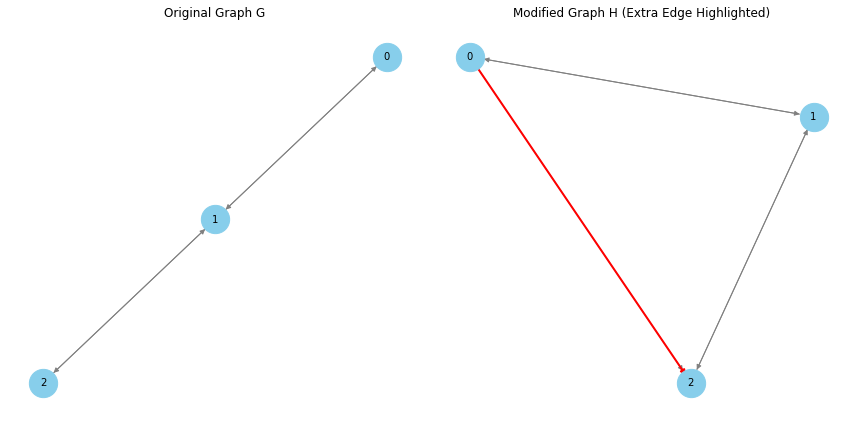

Found one!
EPT: 1.0
EPT: 1.5
extra edge: {(0, 1)}


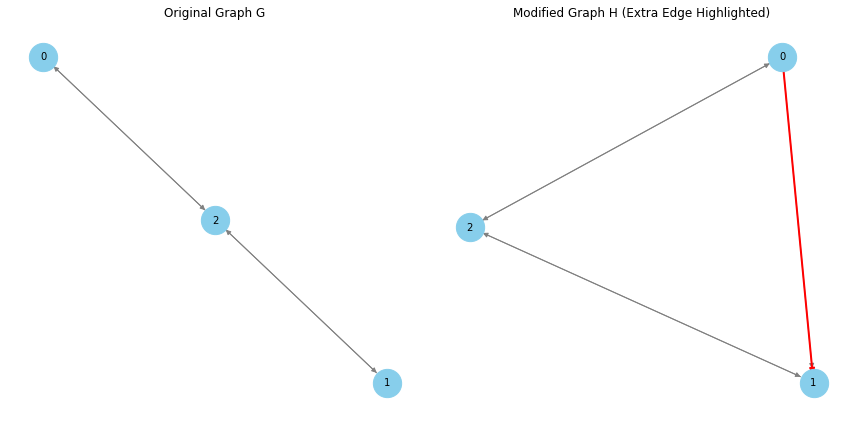

Found one!
EPT: 1.5
EPT: 2.0
extra edge: {(0, 1)}


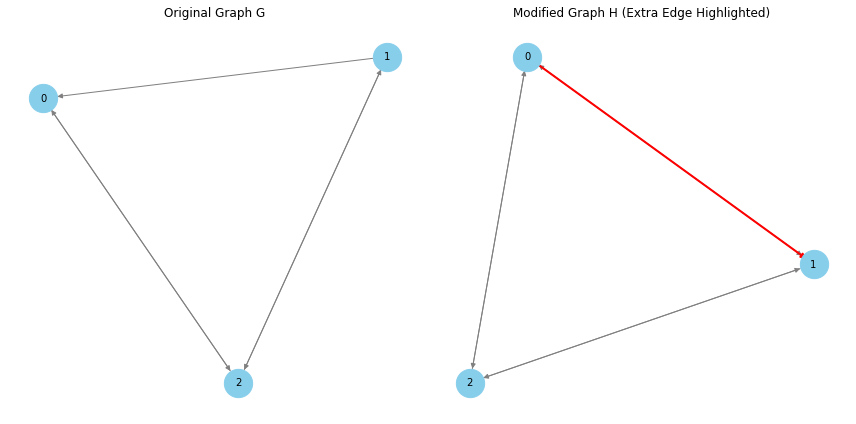

In [2]:
import networkx as nx
import random
import numpy as np



def add_random_edges(G, num_edges):
    """Add `num_edges` random edges to the graph `G`."""
    nodes = list(G.nodes())
    for _ in range(num_edges):
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)

def compute_ept(G):
    """Compute the expected propagation time (EPT) for the graph `G`."""
    graphs = graph_gen(G)
    tm_sparse = tm_generation_directed_sparse(graphs)[0]
    ept, _ = propogation_time_solver_sparse(tm_sparse)
    zfs_size_one_indices = numswithbitcount(2**n, 1)
    ept = np.min(ept[zfs_size_one_indices])
    return ept


n=3
trials = 10
for i in range(trials):
    G = create_connected_random_directed_graph()
    H = G.copy()
    add_random_edges(H, 1)
    if compute_ept(G) < compute_ept(H):
        print("Found one!")
        print("EPT:", compute_ept(G))
        print("EPT:", compute_ept(H))
        print("extra edge:", set(H.edges()) - set(G.edges()))
        import matplotlib.pyplot as plt

        # Plot the original graph G
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        pos_G = nx.spring_layout(G, seed=42)
        nx.draw(G, pos_G, with_labels=True, node_color="skyblue", edge_color="gray", node_size=800, font_size=10)
        plt.title("Original Graph G")

        # Plot the modified graph H with the extra edge highlighted
        plt.subplot(122)
        pos_H = nx.spring_layout(H, seed=42)
        nx.draw(H, pos_H, with_labels=True, node_color="skyblue", edge_color="gray", node_size=800, font_size=10)
        extra_edge = list(set(H.edges()) - set(G.edges()))
        nx.draw_networkx_edges(H, pos_H, edgelist=extra_edge, edge_color="red", width=2.0)
        plt.title("Modified Graph H (Extra Edge Highlighted)")

        plt.tight_layout()
        plt.show()

In [3]:
import pandas as pd
import networkx as nx

# 1. Load Excel file
df = pd.read_excel("/Users/noah01px2019/Downloads/Table.xlsx")

# 2. Extract sector names from column B on rows 8..22 (Excel)
# Excel row 8 → pandas row 7, Excel row 22 → pandas row 21
sector_names = df.iloc[6:21, 1].tolist()   # column 1 = column B

# 3. Build mapping from int → sector name
id_to_sector = {i: name for i, name in enumerate(sector_names)}

# 4. Extract the 15×15 matrix (rows 8..22, cols C..Q)
# Excel rows 8–22 → pandas 7:22
# Excel columns C..Q → pandas 2:17
M = df.iloc[6:21, 2:17].replace('---', 0).astype(float).values

# 5. Build directed graph with nodes labeled by sector name
BEAinputoutputdata = nx.DiGraph()

# add nodes: integer → sector name mapping stored as attribute
for i, name in id_to_sector.items():
    BEAinputoutputdata.add_node(i, label=name)

# 6. Add weighted edges, INCLUDING self-edges
n = len(sector_names)
for i in range(n):          # buyer (row)
    for j in range(n):      # seller (column)
        w = M[i, j]
        if w > 0:
            BEAinputoutputdata.add_edge(j, i, weight=w)

# Debug print: list all self-loops
print("Self-loops:", [(u, v) for u, v in BEAinputoutputdata.edges() if u == v])

# Debug print: verify node labels
print("\nNode labels:")
for node, data in BEAinputoutputdata.nodes(data=True):
    print(node, "→", data["label"])


/Users/noah01px2019/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/noah01px2019/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Self-loops: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14)]

Node labels:
0 → Agriculture, forestry, fishing, and hunting
1 → Mining
2 → Utilities
3 → Construction
4 → Manufacturing
5 → Wholesale trade
6 → Retail trade
7 → Transportation and warehousing
8 → Information
9 → Finance, insurance, real estate, rental, and leasing
10 → Professional and business services
11 → Educational services, health care, and social assistance
12 → Arts, entertainment, recreation, accommodation, and food services
13 → Other services, except government
14 → Government


/var/folders/d7/qc62lrp13l34j7szfq5h0h180000gn/T/ipykernel_55151/3342576858.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  M = df.iloc[6:21, 2:17].replace('---', 0).astype(float).values


In [4]:
n = 15
G = BEAinputoutputdata
print("Self-loops:", [(u, v) for u, v in BEAinputoutputdata.edges() if u == v])
graphs = graph_gen(G)
tm2 = tm_generation_directed_sparse(graphs)[0]
print("solving")
ttres2, tttime2 = propogation_time_solver_sparse(tm2)
zfs_size_one_indices = numswithbitcount(2**n, 1)
zfs_size_one_times = [(int(math.log2(i)), ttres2[i]) for i in zfs_size_one_indices]
min_index = min(range(len(zfs_size_one_times)), key=lambda idx: zfs_size_one_times[idx][1])

Self-loops: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14)]
solving


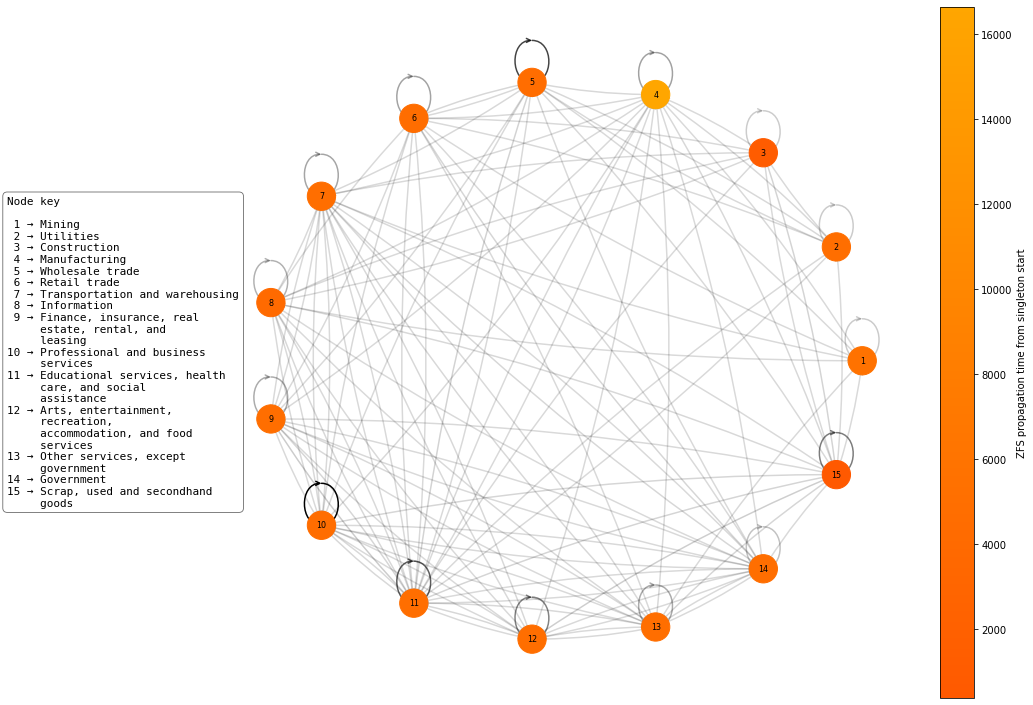

In [11]:
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import textwrap

# --- your node key ---
id_to_sector = {
    0: "Mining",
    1: "Utilities",
    2: "Construction",
    3: "Manufacturing",
    4: "Wholesale trade",
    5: "Retail trade",
    6: "Transportation and warehousing",
    7: "Information",
    8: "Finance, insurance, real estate, rental, and leasing",
    9: "Professional and business services",
    10: "Educational services, health care, and social assistance",
    11: "Arts, entertainment, recreation, accommodation, and food services",
    12: "Other services, except government",
    13: "Government",
    14: "Scrap, used and secondhand goods",
}

def plot_graph_with_zfs_heatmap(
    G,
    zfs_size_one_times,
    shift_labels_by_1=True,
    wrap_width=32,
    key_fontsize=9
):
    times = {node: t for node, t in zfs_size_one_times}
    nodes = list(G.nodes())
    node_values = np.array([times[node] for node in nodes], dtype=float)

    finite_vals = node_values[np.isfinite(node_values)]
    if finite_vals.size == 0:
        raise ValueError("All node values are non-finite (inf/NaN).")
    vmin, vmax = float(finite_vals.min()), float(finite_vals.max())

    # === Build compressed colormap (middle slice of autumn) ===
    base = plt.cm.autumn
    compressed_colors = base(np.linspace(0.35, 0.65, 256))
    compressed_cmap = mcolors.LinearSegmentedColormap.from_list(
        "compressed_autumn", compressed_colors
    )

    # === Figure ===
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_axis_off()

    pos = nx.circular_layout(G)

    # === Edge transparency based on weight ===
    weights = [d.get('weight', 1.0) for _, _, d in G.edges(data=True)]
    w_min, w_max = (min(weights), max(weights)) if weights else (1.0, 1.0)

    def norm_w(w):
        if abs(w_max - w_min) < 1e-12:
            return 0.6
        return 0.15 + 0.85 * ((w - w_min) / (w_max - w_min))

    for u, v, d in G.edges(data=True):
        nx.draw_networkx_edges(
            G, pos,
            ax=ax,
            edgelist=[(u, v)],
            arrows=True,
            arrowstyle='->',
            width=1.5,
            alpha=norm_w(float(d.get('weight', 1.0))),
            connectionstyle="arc3,rad=0.05",
            edge_color="black"
        )

    # === Draw nodes ===
    node_collection = nx.draw_networkx_nodes(
        G, pos,
        ax=ax,
        nodelist=nodes,
        node_color=node_values,
        cmap=compressed_cmap,
        vmin=vmin, vmax=vmax,
        node_size=800
    )

    # === Shift labels by +1 if desired ===
    labels = {node: str(int(node) + 1) for node in nodes} if shift_labels_by_1 else \
             {node: str(int(node)) for node in nodes}
    nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, font_size=8)

    # === Colorbar ===
    cbar = fig.colorbar(node_collection, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label("ZFS propagation time from singleton start")

    # === Multiline-wrapped key (TRANSPARENT BOX) ===
    def wrap_entry(prefix, text, width):
        wrapped = textwrap.fill(
            text,
            width=width,
            subsequent_indent=" " * (len(prefix) + 1),
            break_long_words=False,
            break_on_hyphens=False
        )
        return f"{prefix} {wrapped}"

    key_lines = ["Node key", ""]
    for k in range(15):
        shown_k = k + 1 if shift_labels_by_1 else k
        prefix = f"{shown_k:>2} →"
        key_lines.append(wrap_entry(prefix, id_to_sector[k], wrap_width))

    key_text = "\n".join(key_lines)

    fig.text(
        0.02, 0.5, key_text,
        va="center", ha="left",
        fontsize=key_fontsize,
        family="monospace",
        bbox=dict(
            boxstyle="round,pad=0.4",
            facecolor="none",   # <<< transparent
            edgecolor="0.4",    # subtle gray border
            linewidth=0.8
        ),
    )

    # Minimal margin adjustment (graph stays large)
    plt.subplots_adjust(left=0.22, right=0.98, top=0.98, bottom=0.02)

    plt.show()


# --- run ---
plot_graph_with_zfs_heatmap(
    BEAinputoutputdata,
    zfs_size_one_times,
    shift_labels_by_1=True,
    wrap_width=30,
    key_fontsize=11
)
